# 1 - Appointment no show - Analysis and Prediction

This notebook look at raw data, applies any necessary transformations, visualize features and build a classifier.

Creation date: 12.08.2017


In [1]:
import re
import unicodedata

import joblib

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib notebook

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

/home/arosa/.virtualenvs/ml/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
font = {'family' : 'serif',
        'weight' : 'medium',
        'size'   : 14}

plt.rc('font', **font)
plt.rcParams['axes.facecolor'] = 'white'

#### Load dataset and supplementary neighbourhood data*
(*) collected from brazillian 2010 census. Raw data can be found [here](http://www.ibge.gov.br/home/estatistica/populacao/censo2010/caracteristicas_da_populacao/caracteristicas_da_populacao_tab_municipios_zip_xls.shtm) little wrangling required. [link to cleaned versions](https://drive.google.com/drive/u/2/folders/0B_uxDpjmdSnmQTF5VGtGRUVrTFk)

In [3]:
df = pd.read_csv("./data/KaggleV2-May-2016.csv", index_col=None,
                 parse_dates=["ScheduledDay", "AppointmentDay"], infer_datetime_format=True)

def camelcase_to_snakecase(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

df.columns = df.columns.map(camelcase_to_snakecase)
df.rename(columns={'hipertension':'hypertension', 'handcap':'handicap'}, inplace=True)

df.sort_values(["scheduled_day","appointment_day"], inplace=True, ascending=True)  

In [4]:
df.head()

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no-show
3764,8.322564e+14,5030230,F,2015-11-10 07:13:56,2016-05-04,51,RESISTÊNCIA,0,0,0,0,0,1,No
46292,9.163747e+13,5122866,M,2015-12-03 08:17:28,2016-05-02,34,VILA RUBIM,0,1,0,0,0,1,Yes
102795,1.216587e+12,5134197,F,2015-12-07 10:40:59,2016-06-03,27,SÃO CRISTÓVÃO,1,0,0,0,0,1,Yes
102797,3.189960e+13,5134220,F,2015-12-07 10:42:42,2016-06-03,48,MARUÍPE,0,1,1,0,0,1,No
102796,9.582232e+12,5134223,F,2015-12-07 10:43:01,2016-06-03,80,SÃO CRISTÓVÃO,0,1,1,0,0,1,No


In [5]:
# This data contains the mean incoming of a given neighbourhood.

mean_income = pd.read_csv("./data/mean_incoming_neighborhood.csv", index_col=None)
mean_income.rename(columns={"Mesorregiões, microrregiões, municípios, distritos, subdistritos e bairros":
                                'neighbourhood',
                            "Valor do rendimento nominal mediano mensal das pessoas de 10 anos ou mais de idade (R$)":
                                'neigh_mean_income'},
                    inplace=True)

In [6]:
mean_income.head()

,neighbourhood,neigh_mean_income
0,Andorinhas,510.0
1,Antonio Honório,755.0
2,Ariovaldo Favalessa,510.0
3,Barro Vermelho,2000.0
4,Bela Vista,510.0


In [7]:
# This data contains how the incomes are distributed in
# each neighbourhood for people older than 10 yo.
# Incoming are splitted in 8 ranges.
# people without income are allocated in range_0
# people with incoming lower than half minimun wage are range_1
# and so on...
# The values are the percentages population in the respective range

income_ranges = pd.read_csv("./data/incoming_range_neighborhood.csv", index_col=None)
income_ranges.rename(columns={"Mesorregiões, microrregiões, municípios, distritos, subdistritos e bairros":
                                'neighbourhood',
                            "Sem rendimento (2)": 'neigh_income_range_0',
                            "Até ½ salário mínimo": 'neigh_income_range_1',
                            "Mais de 1/2 a 1 salário mínimo": 'neigh_income_range_2',
                            "Mais de 1 a 2 salário mínimo": 'neigh_income_range_3',
                            "Mais de 2 a 5 salário mínimo": 'neigh_income_range_4',
                            "Mais de 5 a 10 salário mínimo": 'neigh_income_range_5',
                            "Mais de 10 a 20 salário mínimo": 'neigh_income_range_6',
                            "Mais de 20 salário mínimo": 'neigh_income_range_7',
                            },
                    inplace=True)

In [8]:
income_ranges.head()

,neighbourhood,neigh_income_range_1,neigh_income_range_2,neigh_income_range_3,neigh_income_range_4,neigh_income_range_5,neigh_income_range_6,neigh_income_range_7,neigh_income_range_0
0,Andorinhas,0.024349,0.147792,0.293318,0.148924,0.019819,0.002831,0.000000,0.362967
1,Antonio Honório,0.012841,0.123596,0.177368,0.219904,0.121990,0.035313,0.011236,0.297753
2,Ariovaldo Favalessa,0.030928,0.185567,0.241532,0.163476,0.044183,0.007364,0.000000,0.326951
3,Barro Vermelho,0.003529,0.034503,0.065281,0.162713,0.201137,0.173887,0.080572,0.278377
4,Bela Vista,0.038158,0.200872,0.266830,0.118561,0.022349,0.002726,0.000273,0.350232


In [9]:
def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

df.neighbourhood = df.neighbourhood.str.lower()
mean_income.neighbourhood = mean_income.neighbourhood.str.lower()
income_ranges.neighbourhood = income_ranges.neighbourhood.str.lower()

df.neighbourhood = df.neighbourhood.apply(strip_accents)
mean_income.neighbourhood = mean_income.neighbourhood.apply(strip_accents)
income_ranges.neighbourhood = income_ranges.neighbourhood.apply(strip_accents)

In [10]:
# aeroporto isn't a real neighbourhood, changing to nearest one
df.loc[df.neighbourhood == "aeroporto", "neighbourhood"] = "jardim camburi"
# Fixes apostrophe
df.loc[df.neighbourhood == "joana d´arc", "neighbourhood"] = "joana d'arc"
# removing 2 patients from island
df = df[df.neighbourhood != "ilhas oceanicas de trindade"]

In [11]:
df = pd.merge(df, mean_income, left_on="neighbourhood", right_on="neighbourhood", how='left', sort=False)
df.loc[df.neigh_mean_income.isnull(), ["neighbourhood", "neigh_mean_income"]]

,neighbourhood,neigh_mean_income


In [12]:
df = pd.merge(df, income_ranges, left_on="neighbourhood", right_on="neighbourhood", how='left', sort=False)
df.loc[df.neigh_income_range_0.isnull(), ["neighbourhood", "neigh_income_range_0"]]

,neighbourhood,neigh_income_range_0


In [13]:
df.head()

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,...,no-show,neigh_mean_income,neigh_income_range_1,neigh_income_range_2,neigh_income_range_3,neigh_income_range_4,neigh_income_range_5,neigh_income_range_6,neigh_income_range_7,neigh_income_range_0
0,8.322564e+14,5030230,F,2015-11-10 07:13:56,2016-05-04,51,resistencia,0,0,0,...,No,510.0,0.025762,0.263970,0.254717,0.080370,0.008708,0.001270,0.000363,0.364840
1,9.163747e+13,5122866,M,2015-12-03 08:17:28,2016-05-02,34,vila rubim,0,1,0,...,Yes,510.0,0.022745,0.188235,0.224314,0.179608,0.063529,0.012549,0.000784,0.308235
2,1.216587e+12,5134197,F,2015-12-07 10:40:59,2016-06-03,27,sao cristovao,1,0,0,...,Yes,510.0,0.013780,0.184545,0.225615,0.190759,0.062416,0.009727,0.002162,0.310997
3,3.189960e+13,5134220,F,2015-12-07 10:42:42,2016-06-03,48,maruipe,0,1,1,...,No,800.0,0.009980,0.110921,0.184203,0.250071,0.132022,0.032221,0.007129,0.273453
4,9.582232e+12,5134223,F,2015-12-07 10:43:01,2016-06-03,80,sao cristovao,0,1,1,...,No,510.0,0.013780,0.184545,0.225615,0.190759,0.062416,0.009727,0.002162,0.310997


#### Feature Cleaning/Casting

In [14]:
df["no-show"] = df["no-show"].map({"Yes": True, "No": False})
df["show"] = ~df["no-show"]
del[df["no-show"]]

In [15]:
for feature in ["diabetes", "alcoholism", "hypertension", "handicap",
                "scholarship", "sms_received", "neighbourhood"]:
    print("{}: {}".format(feature, df[feature].unique()))

diabetes: [0 1]
alcoholism: [0 1]
hypertension: [0 1]
handicap: [0 1 2 3 4]
scholarship: [0 1]
sms_received: [1 0]
neighbourhood: ['resistencia' 'vila rubim' 'sao cristovao' 'maruipe' 'santa cecilia'
 'tabuazeiro' 'caratoira' 'conquista' 'santos dumont' 'santo andre'
 'redencao' 'bento ferreira' 'monte belo' 'gurigica' 'jucutuquara'
 'praia do canto' 'consolacao' 'cruzamento' 'bela vista' 'centro'
 'santa lucia' 'ilha de santa maria' 'jardim camburi' 'jardim da penha'
 'santa clara' 'bonfim' 'jesus de nazareth' 'jabour' 'sao jose' 'sao pedro'
 'santo antonio' 'maria ortiz' 'itarare' 'santa tereza' 'universitario'
 'inhangueta' 'ilha do principe' 'romao' 'santa martha' 'andorinhas'
 'santa luiza' 'da penha' 'do quadro' 'parque moscoso' 'grande vitoria'
 'forte sao joao' "joana d'arc" 'de lourdes' 'santos reis'
 'ariovaldo favalessa' 'horto' 'fonte grande' 'goiabeiras' 'sao benedito'
 'nova palestina' 'enseada do sua' 'do cabral' 'piedade' 'republica'
 'do moscoso' 'ilha das caieiras' 'f

In [16]:
boolean_features = ["diabetes", "alcoholism", "hypertension", "sms_received", "scholarship"]
categorical_features = ["gender", "handicap", "neighbourhood", "patient_id", "appointment_id"]

df.age = df.age.astype("int")
df.patient_id = df.patient_id.astype("int")
df.appointment_id = df.appointment_id.astype("int")

for feature in boolean_features:
    df[feature] = df[feature].astype("bool")

for feature in categorical_features:
    df[feature] = df[feature].astype("category")

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110525 entries, 0 to 110524
Data columns (total 23 columns):
patient_id              110525 non-null category
appointment_id          110525 non-null category
gender                  110525 non-null category
scheduled_day           110525 non-null datetime64[ns]
appointment_day         110525 non-null datetime64[ns]
age                     110525 non-null int64
neighbourhood           110525 non-null category
scholarship             110525 non-null bool
hypertension            110525 non-null bool
diabetes                110525 non-null bool
alcoholism              110525 non-null bool
handicap                110525 non-null category
sms_received            110525 non-null bool
neigh_mean_income       110525 non-null float64
neigh_income_range_1    110525 non-null float64
neigh_income_range_2    110525 non-null float64
neigh_income_range_3    110525 non-null float64
neigh_income_range_4    110525 non-null float64
neigh_income_range_5   

In [18]:
df.head()

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,...,neigh_mean_income,neigh_income_range_1,neigh_income_range_2,neigh_income_range_3,neigh_income_range_4,neigh_income_range_5,neigh_income_range_6,neigh_income_range_7,neigh_income_range_0,show
0,832256398961987,5030230,F,2015-11-10 07:13:56,2016-05-04,51,resistencia,False,False,False,...,510.0,0.025762,0.263970,0.254717,0.080370,0.008708,0.001270,0.000363,0.364840,True
1,91637474953513,5122866,M,2015-12-03 08:17:28,2016-05-02,34,vila rubim,False,True,False,...,510.0,0.022745,0.188235,0.224314,0.179608,0.063529,0.012549,0.000784,0.308235,False
2,1216586867796,5134197,F,2015-12-07 10:40:59,2016-06-03,27,sao cristovao,True,False,False,...,510.0,0.013780,0.184545,0.225615,0.190759,0.062416,0.009727,0.002162,0.310997,False
3,31899595421534,5134220,F,2015-12-07 10:42:42,2016-06-03,48,maruipe,False,True,True,...,800.0,0.009980,0.110921,0.184203,0.250071,0.132022,0.032221,0.007129,0.273453,True
4,9582232334148,5134223,F,2015-12-07 10:43:01,2016-06-03,80,sao cristovao,False,True,True,...,510.0,0.013780,0.184545,0.225615,0.190759,0.062416,0.009727,0.002162,0.310997,True


In [19]:
df.describe(include="all")

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,...,neigh_mean_income,neigh_income_range_1,neigh_income_range_2,neigh_income_range_3,neigh_income_range_4,neigh_income_range_5,neigh_income_range_6,neigh_income_range_7,neigh_income_range_0,show
count,1.105250e+05,110525.0,110525,110525,110525,110525.000000,110525,110525,110525,110525,...,110525.000000,110525.000000,110525.000000,110525.000000,110525.000000,110525.000000,110525.000000,110525.000000,110525.000000,110525
unique,6.229700e+04,110525.0,2,103547,27,NaN,79,2,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,8.221459e+14,5790484.0,F,2016-05-06 07:09:54,2016-06-06 00:00:00,NaN,jardim camburi,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
freq,8.800000e+01,1.0,71838,24,4692,NaN,7725,99664,88724,102582,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88208
first,NaN,NaN,NaN,2015-11-10 07:13:56,2016-04-29 00:00:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2016-06-08 20:07:23,2016-06-08 00:00:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,37.088559,NaN,NaN,NaN,NaN,...,710.553757,0.021964,0.175226,0.219975,0.154823,0.068309,0.024874,0.006801,0.328026,NaN
std,NaN,NaN,NaN,NaN,NaN,23.110291,NaN,NaN,NaN,NaN,...,387.325017,0.012370,0.067892,0.056168,0.057858,0.068219,0.037154,0.015772,0.046963,NaN
min,NaN,NaN,NaN,NaN,NaN,-1.000000,NaN,NaN,NaN,NaN,...,405.000000,0.000000,0.015831,0.064346,0.045760,0.000000,0.000000,0.000000,0.248547,NaN
25%,NaN,NaN,NaN,NaN,NaN,18.000000,NaN,NaN,NaN,NaN,...,510.000000,0.009980,0.110921,0.184203,0.102356,0.017996,0.002769,0.000347,0.294949,NaN


### Creating Features

In [20]:
df["days_delta"] = (df.appointment_day - pd.to_datetime(df.scheduled_day.dt.date)).dt.days

In [21]:
# Using only prior appointments
def calculate_prior_noshow(row):
    previous_appoint = df.loc[(df.patient_id == row["patient_id"]) & (df.appointment_day <= row["scheduled_day"]), "show"]
    row["previous_appoint_count"] = len(previous_appoint)
    row["previous_appoint_shows"] = previous_appoint.sum()
    return row
          
df = df.apply(calculate_prior_noshow, axis=1)
df = df.drop(["patient_id", "appointment_id"], axis=1)

In [22]:
boolean_features = ["diabetes", "alcoholism", "hypertension", "sms_received", "scholarship"]
categorical_features = ["gender", "handicap", "neighbourhood"]

df.age = df.age.astype("int")

for feature in boolean_features:
    df[feature] = df[feature].astype("bool")

for feature in categorical_features:
    df[feature] = df[feature].astype("category")

### Fixing visible data errors

In [23]:
# considering the only case of negative age as typos
df.loc[df.age < 0, "age"] = int(df.age.mode())

# considering the few (6) cases of past schedule as typos
df.loc[df.days_delta < 0, "days_delta"] = int(df.days_delta.mode())

In [24]:
df["ln_days_delta"] = np.log(df.days_delta + 1)
df = df.drop(["days_delta"], axis=1)

### Plot Data Distributions

<IPython.core.display.Javascript object>


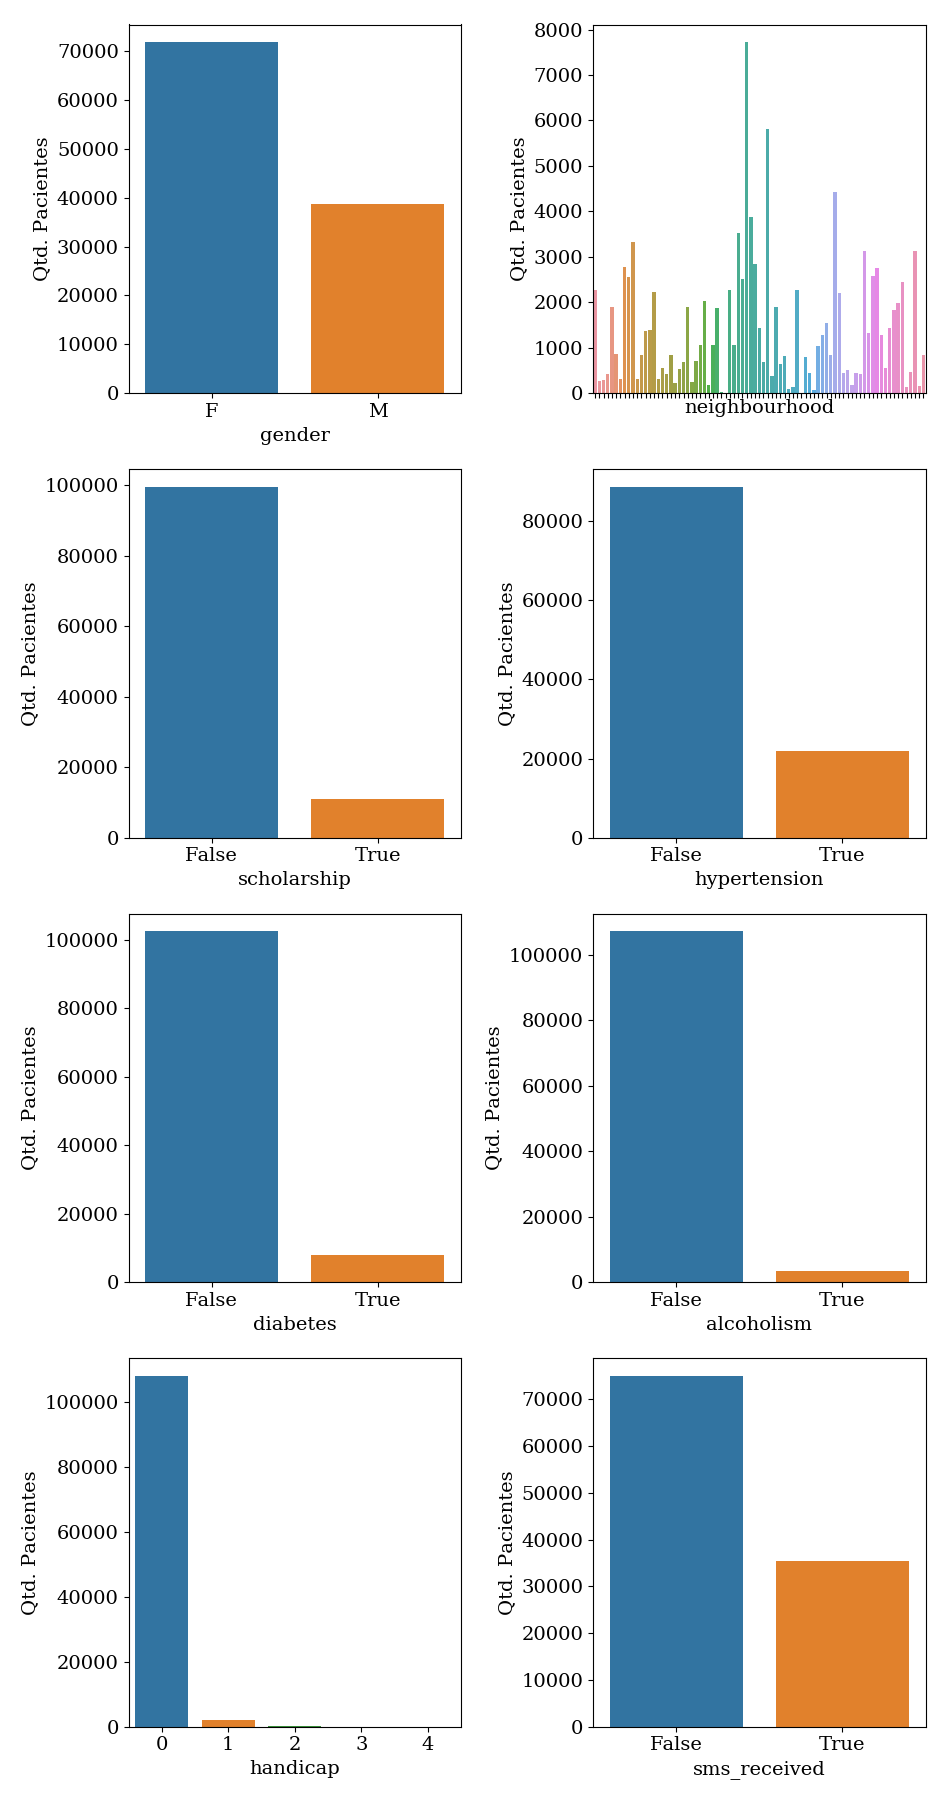

In [25]:
plt.figure(figsize=(9.5,18))
gs = gridspec.GridSpec(4, 2)

features = df.select_dtypes(include=["category", "bool"]).columns.drop(["show"])

for i, feature in enumerate(features):
    ax = plt.subplot(gs[(i // 2), (i % 2)])
    plot = sns.countplot(df[feature], ax=ax)
    plot.set_ylabel("Qtd. Pacientes")
    if feature == "neighbourhood":
        ax.tick_params(labelbottom="off")
    
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


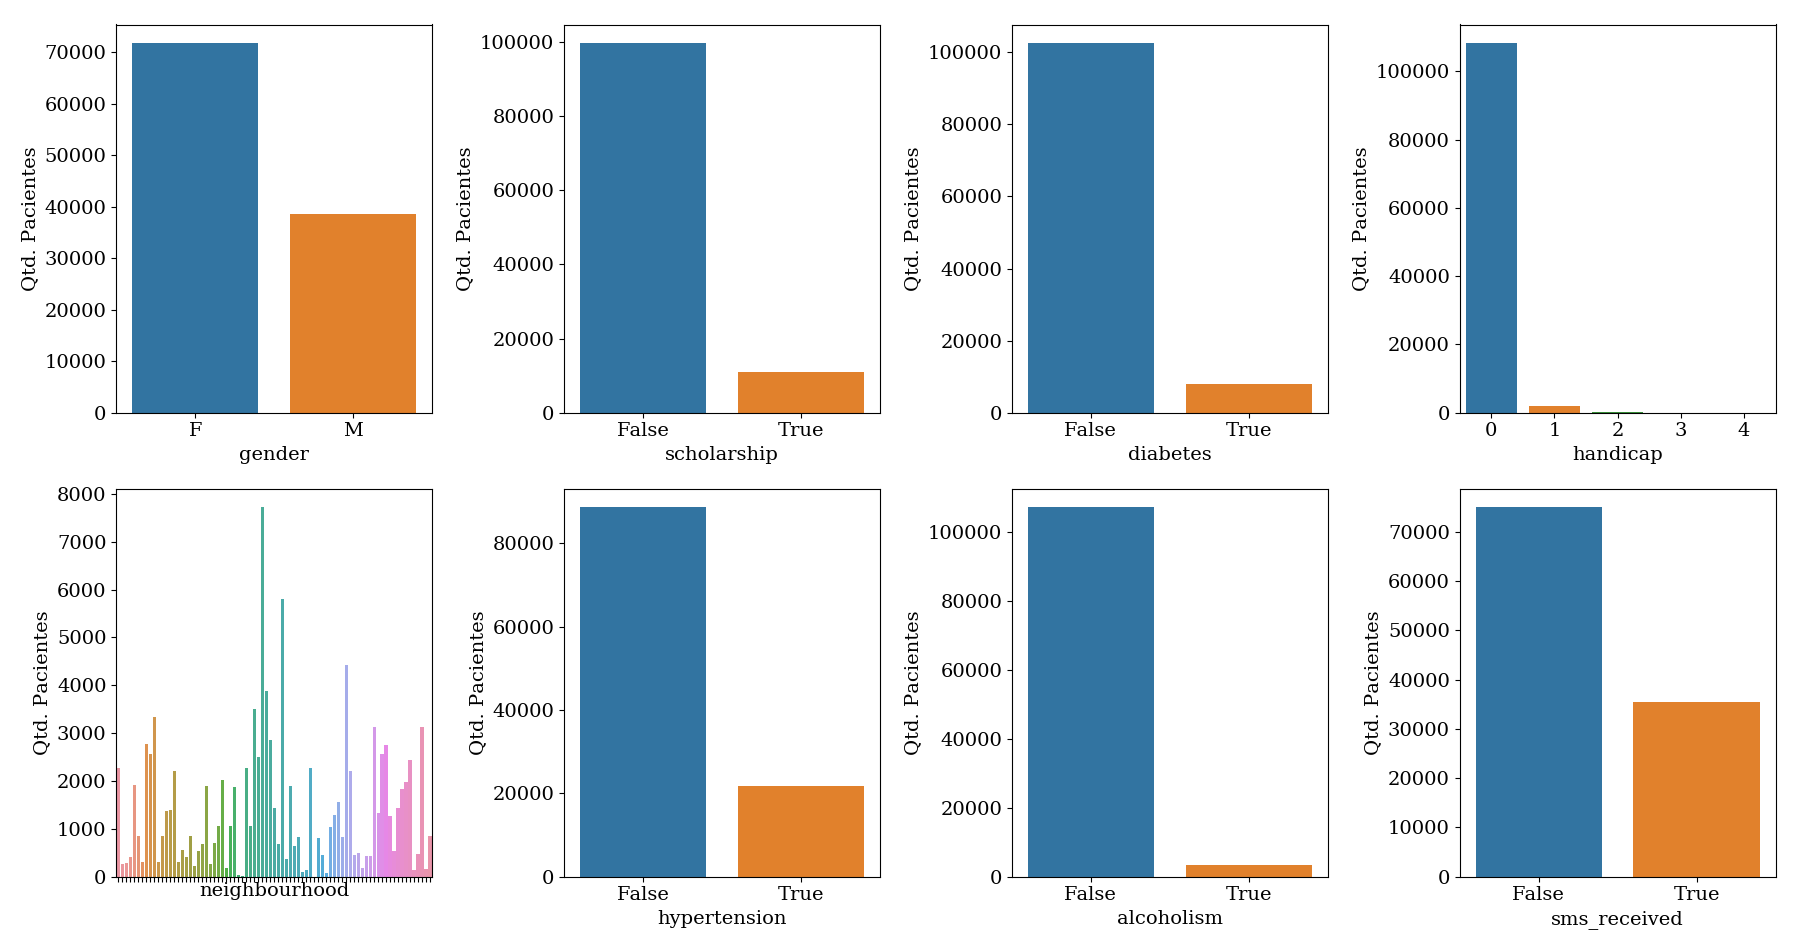

In [26]:
plt.figure(figsize=(18,9.5))
gs = gridspec.GridSpec(2, 4)

features = df.select_dtypes(include=["category", "bool"]).columns.drop(["show"])

for i, feature in enumerate(features):
    ax = plt.subplot(gs[(i % 2), (i // 2)])
    plot = sns.countplot(df[feature], ax=ax)
    plot.set_ylabel("Qtd. Pacientes")
    if feature == "neighbourhood":
        ax.tick_params(labelbottom="off")
    
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


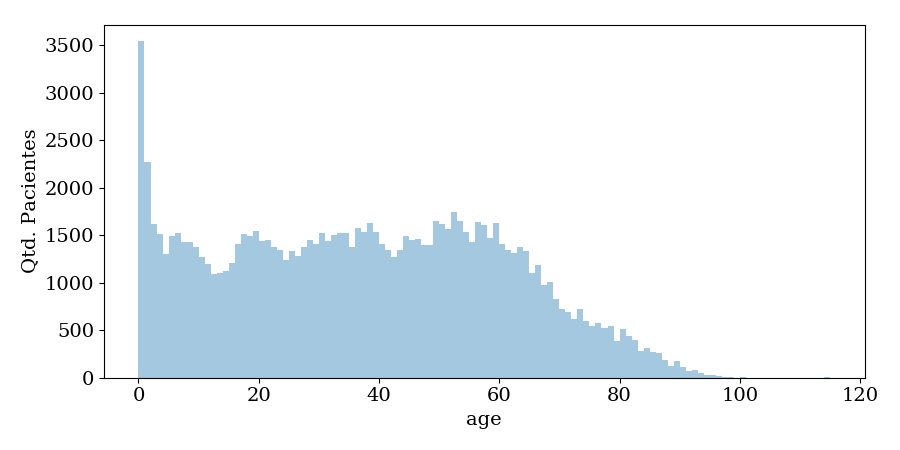

In [27]:
plt.figure(figsize=(9, 4.5))
sns.distplot(df.age, bins=df.age.max(), kde=False)
plt.ylabel("Qtd. Pacientes")
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


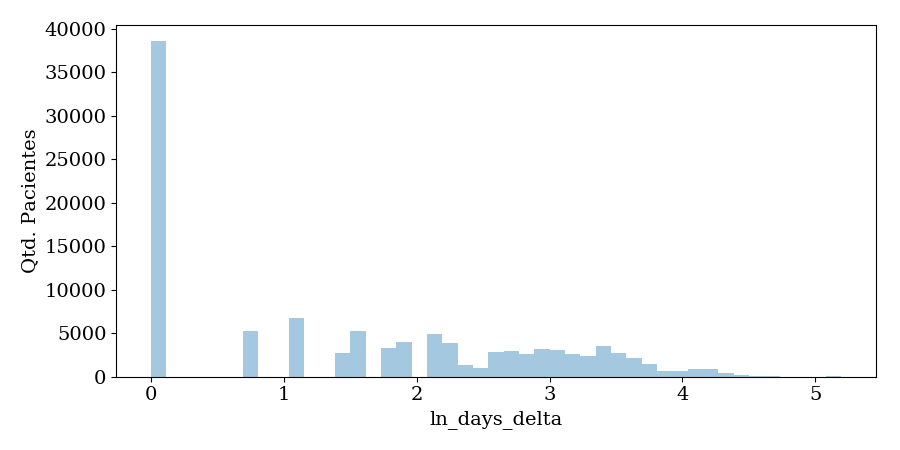

In [28]:
plt.figure(figsize=(9, 4.5))
sns.distplot(df.ln_days_delta, kde=False)
plt.ylabel("Qtd. Pacientes")
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


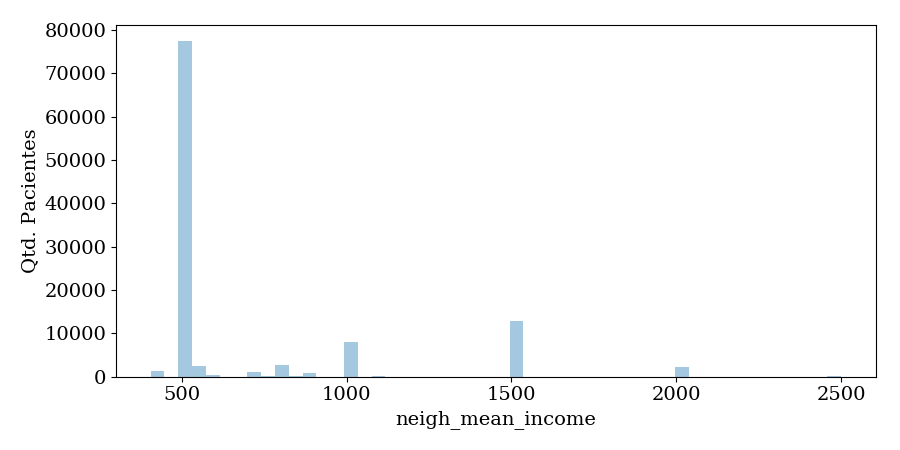

In [29]:
plt.figure(figsize=(9, 4.5))
sns.distplot(df.neigh_mean_income, kde=False)
plt.ylabel("Qtd. Pacientes")
plt.tight_layout()
plt.show()

### Plot Show/No-Show Distribution

<IPython.core.display.Javascript object>


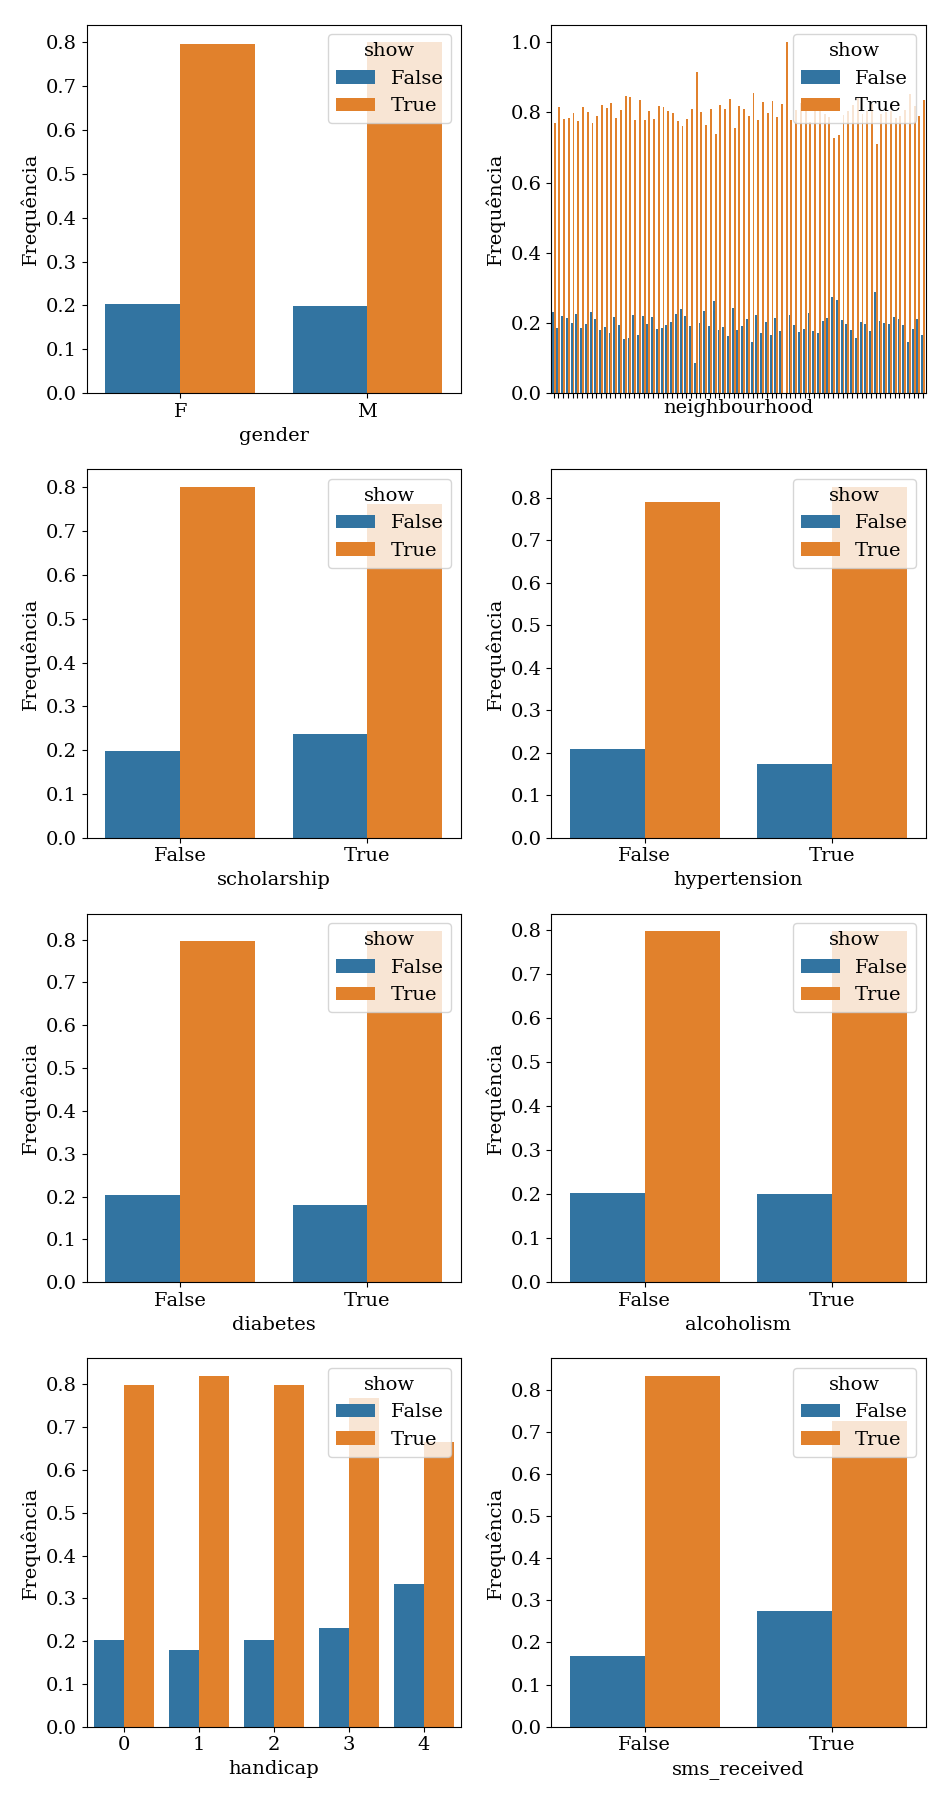

In [30]:
plt.figure(figsize=(9.5,18))
gs = gridspec.GridSpec(4, 2)

features = df.select_dtypes(include=["category", "bool"]).columns.drop(["show"])

for i, feature in enumerate(features):
    
    feature_counts = (df.groupby([feature])["show"]
                            .value_counts(normalize=True)
                            .rename('frequence')
                            .reset_index()
                            .sort_values(feature))
    
    ax = plt.subplot(gs[(i // 2), (i % 2)])
    plot = sns.barplot(x=feature, y="frequence", hue="show",
                       data=feature_counts, ax=ax)
    plot.set_ylabel("Frequência")
    plot.set_xlabel(feature)
    if feature == "neighbourhood":
        ax.tick_params(labelbottom="off")

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


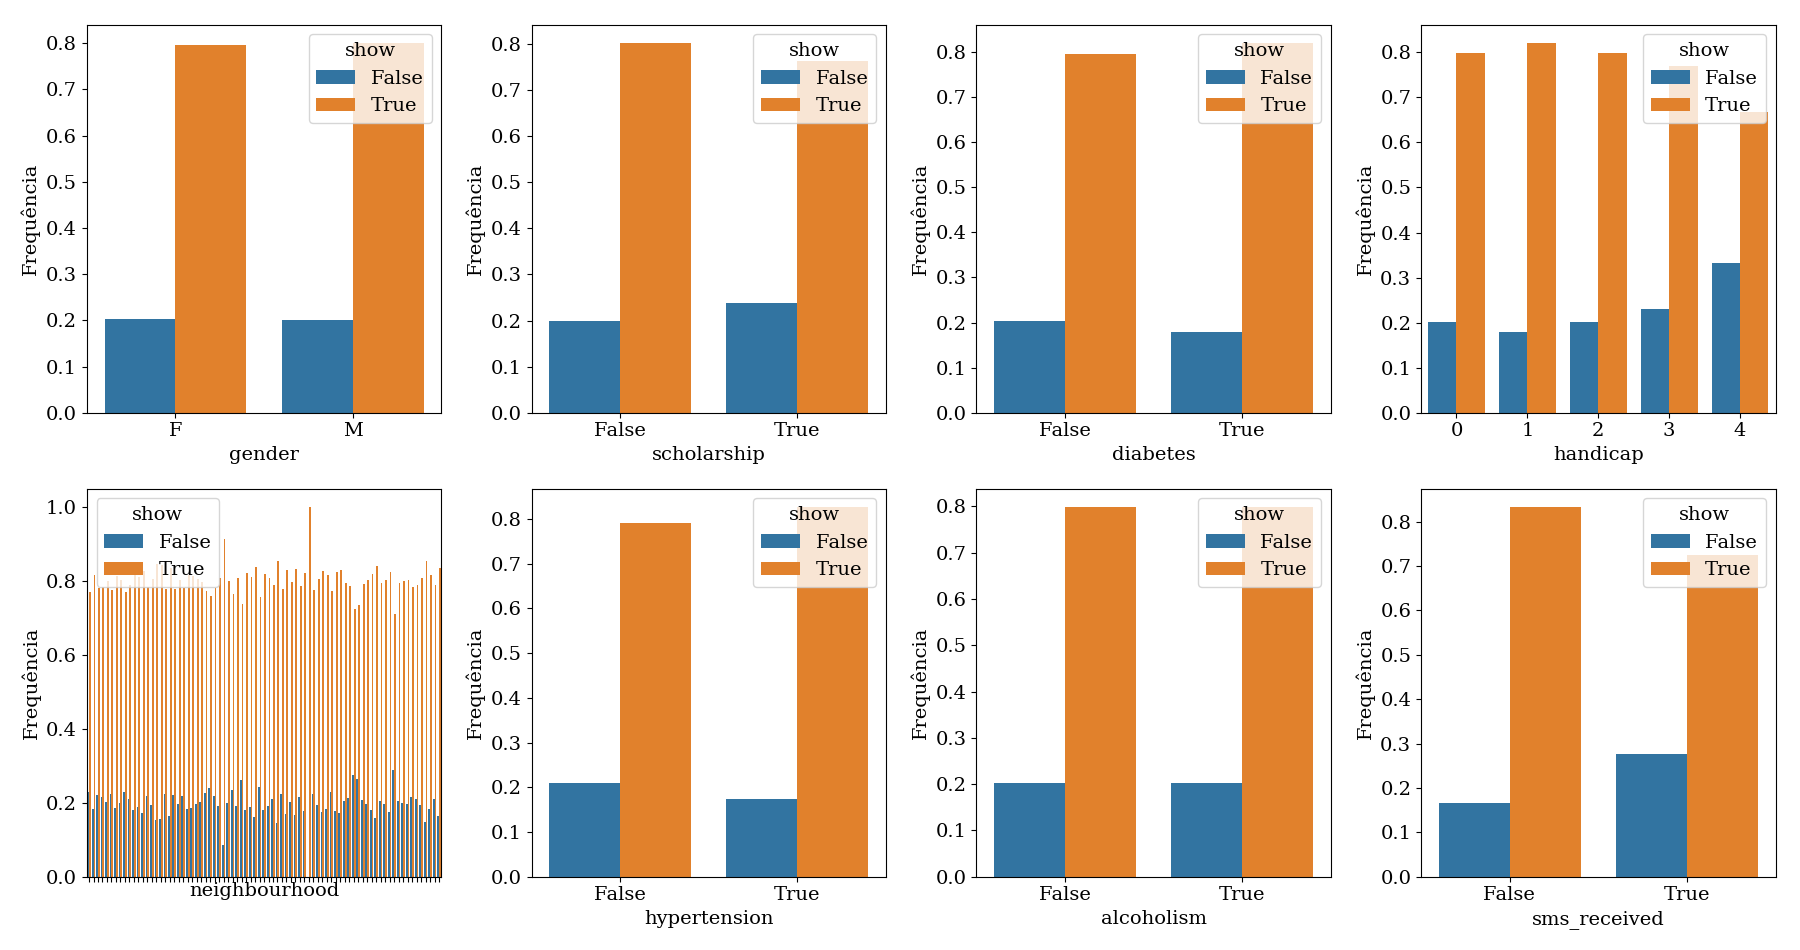

In [31]:
plt.figure(figsize=(18,9.5))
gs = gridspec.GridSpec(2, 4)

features = df.select_dtypes(include=["category", "bool"]).columns.drop(["show"])

for i, feature in enumerate(features):
    
    feature_counts = (df.groupby([feature])["show"]
                            .value_counts(normalize=True)
                            .rename('frequence')
                            .reset_index()
                            .sort_values(feature))
    
    ax = plt.subplot(gs[(i % 2), (i // 2)])
    plot = sns.barplot(x=feature, y="frequence", hue="show",
                       data=feature_counts, ax=ax)
    plot.set_ylabel("Frequência")
    plot.set_xlabel(feature)
    if feature == "neighbourhood":
        ax.tick_params(labelbottom="off")

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


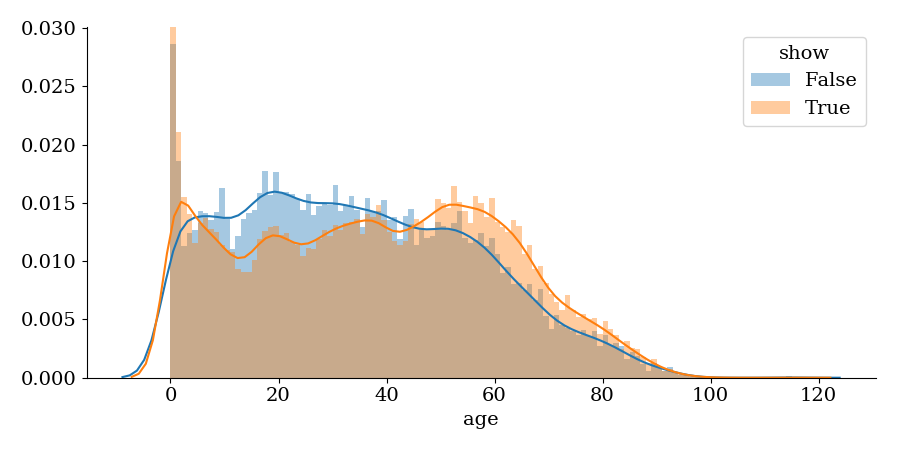

In [32]:
ax = sns.FacetGrid(df, hue="show", size=4.5, aspect=2)
ax = ax.map(sns.distplot, "age", bins=df.age.max(), kde=True)
plt.legend(loc='upper right', title="show")
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


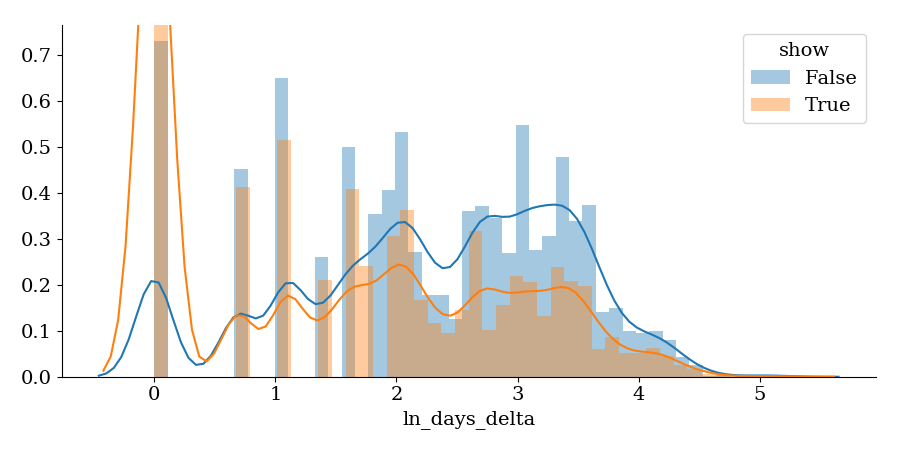

In [33]:
ax = sns.FacetGrid(df, hue="show", size=4.5, aspect=2)
ax = ax.map(sns.distplot, "ln_days_delta", kde=True)
plt.legend(loc='upper right', title="show")
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


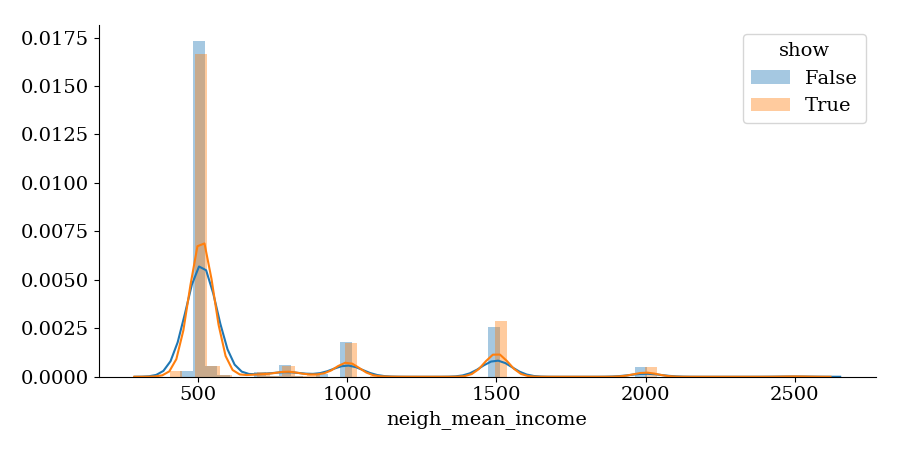

In [34]:
ax = sns.FacetGrid(df, hue="show", size=4.5, aspect=2)
ax = ax.map(sns.distplot, "neigh_mean_income", kde=True)
plt.legend(loc='upper right', title="show")
plt.tight_layout()
plt.show()

In [35]:
# transformimg date values into sin/cos

# hour of registration
angle = df.scheduled_day.dt.hour * (2 * np.pi) / 24
df["registration_hour_sin"] = np.sin(angle)
df["registration_hour_cos"] = np.cos(angle)

# Day of the week (appointment)
angle = df.appointment_day.dt.dayofweek * (2 * np.pi) / 7
df["appointment_week_sin"] = np.sin(angle)
df["appointment_week_cos"] = np.cos(angle)

# Day of the month (appointment)
angle = df.appointment_day.dt.day * (2 * np.pi) / df.appointment_day.dt.days_in_month
df["appointment_month_sin"] = np.sin(angle)
df["appointment_month_cos"] = np.cos(angle)

# Day of the year (appointment)
angle = df.appointment_day.dt.dayofyear * (2 * np.pi) / 365 
df["appointment_year_sin"] = np.sin(angle)
df["appointment_year_cos"] = np.cos(angle)

# Dropping registration date, appointment date and day_of_the_week
df = df.drop(["appointment_day", "scheduled_day"], axis=1)

In [36]:
df.head()

,gender,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,neigh_mean_income,...,previous_appoint_shows,ln_days_delta,registration_hour_sin,registration_hour_cos,appointment_week_sin,appointment_week_cos,appointment_month_sin,appointment_month_cos,appointment_year_sin,appointment_year_cos
0,F,51,resistencia,False,False,False,False,0,True,510.0,...,0,5.176150,0.965926,-0.258819,0.974928,-0.222521,0.724793,0.688967,0.835925,-0.548843
1,M,34,vila rubim,False,True,False,False,0,True,510.0,...,0,5.023881,0.866025,-0.500000,0.000000,1.000000,0.394356,0.918958,0.854322,-0.519744
2,F,27,sao cristovao,True,False,False,False,0,True,510.0,...,0,5.192957,0.500000,-0.866025,-0.433884,-0.900969,0.587785,0.809017,0.455907,-0.890028
3,F,48,maruipe,False,True,True,False,0,True,800.0,...,0,5.192957,0.500000,-0.866025,-0.433884,-0.900969,0.587785,0.809017,0.455907,-0.890028
4,F,80,sao cristovao,False,True,True,False,0,True,510.0,...,0,5.192957,0.500000,-0.866025,-0.433884,-0.900969,0.587785,0.809017,0.455907,-0.890028


### Feature selection by Pearson correlation with output

In [37]:
one_hot_features = pd.get_dummies(df.drop(["show", "neighbourhood"], axis=1)).columns
X = pd.get_dummies(df.drop(["show", "neighbourhood"], axis=1)).values
y = df.show.values

X = X.astype("float64")
y = y.astype("float64")

In [38]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.3, random_state=7)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=.5, random_state=7)

In [39]:
train_df = pd.DataFrame(data=X_train, columns=one_hot_features)
train_df["show"] = y_train
train_df.head()

,age,scholarship,hypertension,diabetes,alcoholism,sms_received,neigh_mean_income,neigh_income_range_1,neigh_income_range_2,neigh_income_range_3,...,appointment_year_sin,appointment_year_cos,gender_F,gender_M,handicap_0,handicap_1,handicap_2,handicap_3,handicap_4,show
0,54.0,0.0,0.0,0.0,0.0,0.0,510.0,0.038158,0.200872,0.266830,...,0.816538,-0.577292,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,23.0,0.0,0.0,0.0,0.0,0.0,510.0,0.027027,0.186010,0.172099,...,0.693281,-0.720667,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,55.0,0.0,1.0,0.0,0.0,1.0,1500.0,0.005108,0.057268,0.115990,...,0.409356,-0.912375,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,16.0,0.0,0.0,0.0,0.0,1.0,510.0,0.036604,0.252726,0.229361,...,0.880012,-0.474951,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,53.0,0.0,0.0,0.0,0.0,0.0,510.0,0.023507,0.254721,0.260501,...,0.752667,-0.658402,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [40]:
corr_tresh = 2 / np.sqrt(X_train.shape[0])
corr_tresh

0.0071903845442286606

In [41]:
r = pd.DataFrame(train_df.corr())
output_r = pd.DataFrame(r.loc[:, "show"].abs())
output_r["correlated"] = output_r > corr_tresh
print("Correlation treshold: {:.4f}".format(corr_tresh))
output_r

Correlation treshold: 0.0072


,show,correlated
age,0.063309,True
scholarship,0.030017,True
hypertension,0.037005,True
diabetes,0.012499,True
alcoholism,0.002352,False
sms_received,0.126848,True
neigh_mean_income,0.016517,True
neigh_income_range_1,0.014949,True
neigh_income_range_2,0.015870,True
neigh_income_range_3,0.016479,True


<IPython.core.display.Javascript object>


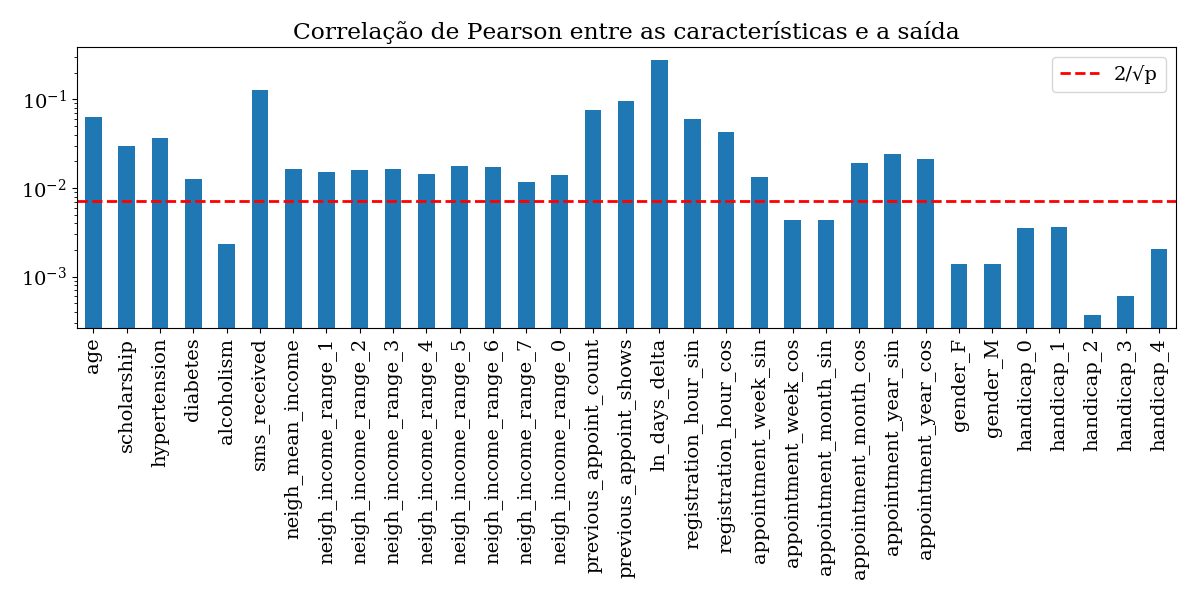

In [42]:
plt.figure(figsize=(12, 6))
plt.title("Pearson correlation between feature and output")
plt.title("Correlação de Pearson entre as características e a saída")
output_r.loc[output_r.index != "show", "show"].plot(kind="bar", label="")
tresh_line = plt.axhline(corr_tresh, linewidth=2, linestyle="--", color='r', label="2/√p")
plt.yscale("log")
plt.legend()
plt.tight_layout()
plt.show()

Removing gender and alcoholism as they are not correlated enough with the output.

In [43]:
one_hot_features = pd.get_dummies(df.drop(["show", "neighbourhood", "alcoholism", "gender"], axis=1)).columns
X = pd.get_dummies(df.drop(["show", "neighbourhood", "alcoholism", "gender"], axis=1)).values
y = df.show.values

X = X.astype("float64")
y = y.astype("float64")

In [44]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.3, random_state=7)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=.5, random_state=7)

In [45]:
one_hot_features

Index(['age', 'scholarship', 'hypertension', 'diabetes', 'sms_received',
       'neigh_mean_income', 'neigh_income_range_1', 'neigh_income_range_2',
       'neigh_income_range_3', 'neigh_income_range_4', 'neigh_income_range_5',
       'neigh_income_range_6', 'neigh_income_range_7', 'neigh_income_range_0',
       'previous_appoint_count', 'previous_appoint_shows', 'ln_days_delta',
       'registration_hour_sin', 'registration_hour_cos',
       'appointment_week_sin', 'appointment_week_cos', 'appointment_month_sin',
       'appointment_month_cos', 'appointment_year_sin', 'appointment_year_cos',
       'handicap_0', 'handicap_1', 'handicap_2', 'handicap_3', 'handicap_4'],
      dtype='object')

#### Scaling Features

In [46]:
scaled_features = np.flatnonzero(one_hot_features.str.startswith("neigh_income_range_") |
                                 one_hot_features.str.startswith("previous_appoint_") |
                                 one_hot_features.isin(["age", "ln_days_delta", "neigh_mean_income"]))

scaler = StandardScaler()
scaler.fit(X_train[:, scaled_features])
joblib.dump(scaler, "trained_models/scaler.p")

['trained_models/scaler.p']

In [47]:
X_train[:, scaled_features] = scaler.transform(X_train[:, scaled_features])
X_val[:, scaled_features] = scaler.transform(X_val[:, scaled_features])
X_test[:, scaled_features] = scaler.transform(X_test[:, scaled_features])

In [48]:
joblib.dump(X_train, "preprocessed_data/X_train.p")
joblib.dump(X_val, "preprocessed_data/X_val.p")
joblib.dump(X_test, "preprocessed_data/X_test.p")

joblib.dump(y_train, "preprocessed_data/y_train.p")
joblib.dump(y_val, "preprocessed_data/y_val.p")
joblib.dump(y_test, "preprocessed_data/y_test.p")

['preprocessed_data/y_test.p']

In [49]:
X_train.shape, X_val.shape, X_test.shape

((77367, 30), (16579, 30), (16579, 30))

In [50]:
clf = LogisticRegression(class_weight="balanced")

clf_grid = GridSearchCV(estimator=clf,
                        param_grid={
                            "C": np.logspace(-3, 2, num=10),
                        },
                        cv=KFold(n_splits=3, shuffle=True),
                        scoring='roc_auc',
                        n_jobs=-1,
                        refit=True
)

In [51]:
clf_grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-03,   3.59381e-03,   1.29155e-02,   4.64159e-02,
         1.66810e-01,   5.99484e-01,   2.15443e+00,   7.74264e+00,
         2.78256e+01,   1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

<IPython.core.display.Javascript object>


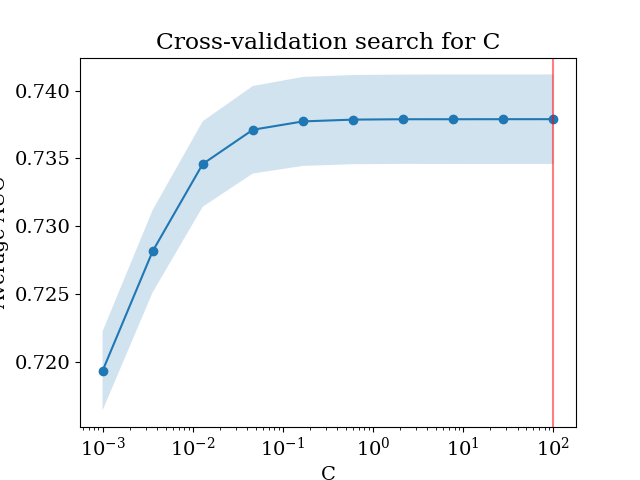

In [52]:
plt.figure()
plt.fill_between(
    list(clf_grid.cv_results_['param_C']),
    [(mean - std) for mean, std in zip(clf_grid.cv_results_["mean_test_score"], clf_grid.cv_results_["std_test_score"])],
    [(mean + std) for mean, std in zip(clf_grid.cv_results_["mean_test_score"], clf_grid.cv_results_["std_test_score"])],
    alpha=0.2
)
plt.plot(
    list(clf_grid.cv_results_['param_C']),
    [x for x in clf_grid.cv_results_["mean_test_score"]],
    '-o'
)
plt.axvline(clf_grid.best_params_["C"], color='r', alpha=0.5)
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("Average AUC")
plt.title("Cross-validation search for C")
plt.show()

In [53]:
clf = clf_grid.best_estimator_

<IPython.core.display.Javascript object>


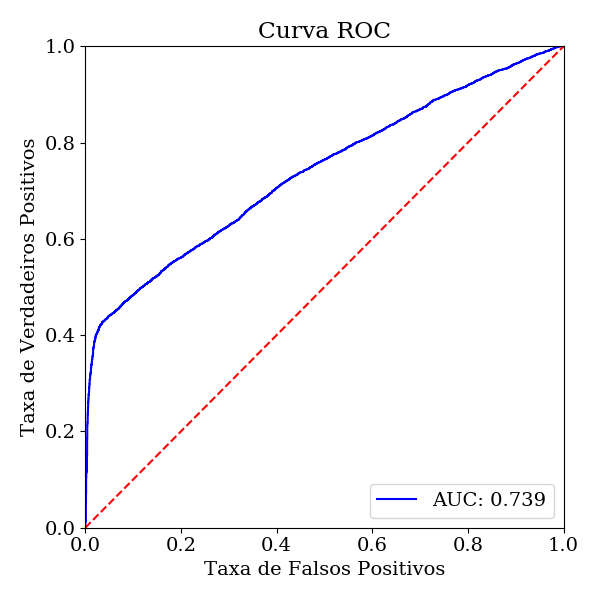

In [54]:
plt.figure(figsize=(6,6))
fpr, tpr, thresh = roc_curve(y_val, clf.predict_proba(X_val)[:,1])
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve')
plt.title('Curva ROC')
plt.plot(fpr, tpr, 'b', label="AUC: {:.3f}".format(roc_auc))
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.xlabel('Taxa de Falsos Positivos')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


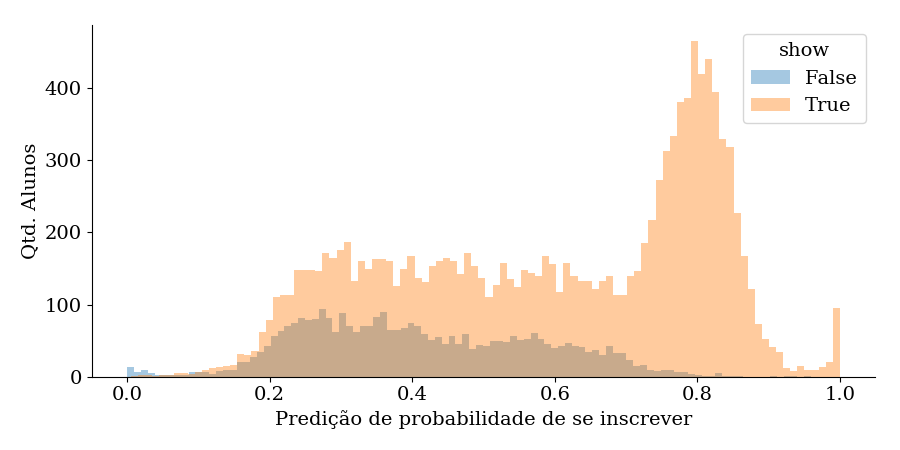

In [55]:
y_prob = clf.predict_proba(X_val)[:, 1].squeeze()
prob_dist = pd.DataFrame({"prob": y_prob, "label": y_val.astype("bool")})
ax = sns.FacetGrid(prob_dist, hue="label", size=4.5, aspect=2)

ax = ax.map(sns.distplot, "prob", bins=100, kde=False)
plt.legend(title="show")
plt.xlabel("Predição de probabilidade de se inscrever")
plt.ylabel("Qtd. Alunos")
plt.tight_layout()
plt.show()

In [56]:
clf = XGBClassifier(n_estimators=400,
                    scale_pos_weight=((y_train == 0).sum() / y_train.sum()))
clf.silent = False

In [57]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=400, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=0.25323160657012345, seed=0, silent=False,
       subsample=1)

In [58]:
clf.score(X_val, y_val)

0.6163821702153327

<IPython.core.display.Javascript object>


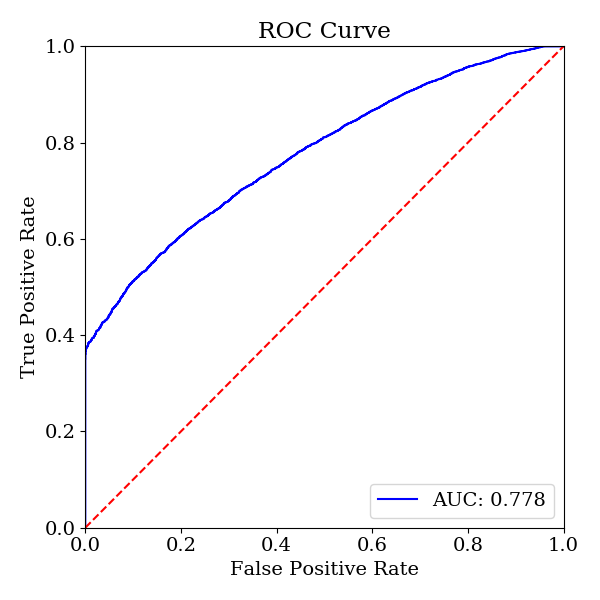

In [59]:
plt.figure(figsize=(6,6))
fpr, tpr, thresh = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label="AUC: {:.3f}".format(roc_auc))
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


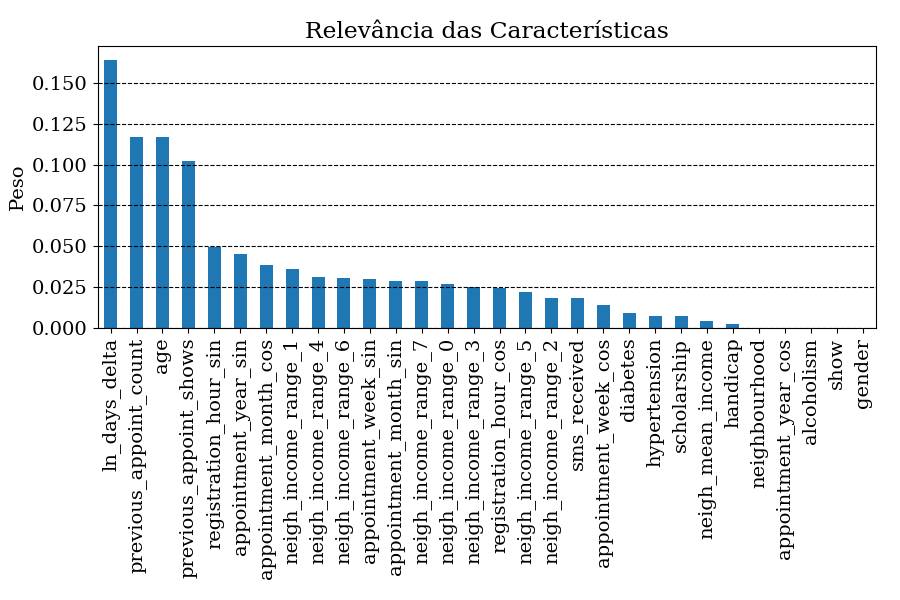

In [60]:
features_importance = pd.Series(index=df.columns)

for feat in df.columns:
    feat_importance = one_hot_features.str.startswith(feat) * clf.feature_importances_
    features_importance[feat] = feat_importance.sum()

features_importance.sort_values(ascending=False, inplace=True)


fea
plt.figure(figsize=(9, 6))
features_importance.plot(kind="bar")
plt.title("Relevância das Características")
plt.ylabel("Peso")
plt.grid(axis="y", color="k", linestyle="--")
plt.tight_layout()
plt.show()